# Regression with non-Gaussian likelihood and outliers 

### Scientific value:


Regression with Gaussian noise does, in practice not cope very well with outliers (FIXME - assertion; put reference here). We therefore like to make
assumptions about the noise that differ from it being Gaussian. A common solution is to assume t-distributed noise.

Assuming t-distributed noise has the effect that a non-Gaussian likelihood has to be optimized (or a posterior inferred ) - which is hard.

We reproduce [section 7 in a paper by Radford Neal; 2005)](https://arxiv.org/pdf/physics/9701026v2.pdf).

### Deliverables

What currently does not work is gradient-based inference and scalar input for GPs. For now, we need to ensure that a GP can process input in  form of:

- scalars;

- 1- d arrays (to model vectors);

- multi-dimensional arrays (to model matrices);

a) **Scalar input GPs.**

In the future, we should allow GPs to cope with all kinds of input that can be used for a covariance function. For now, we only focus on the three above.

=> Who is delivering this? Ulli with Taylor's help.


b) **Gradient-based inference.** For now, gradient ascent inference is sufficient.

=> Who is delivering this? Taylor with Ulli's help.


### Goal

For this effort we have two goals:

1. We want to show a plot of posterior samples drawn from the GP (like the current version of Fig 2) that shows that the posterior (i) captures the underlying fuction that generates (unlike the current version of Fig. 2) the data and (ii) that does not get confused by outliers.

2. We want to show that the hyper-parameter posterior distribution (Fig. 4) differs from the prior on hyper-parameters (Fig 3).


This entails getting rid of the helper-SPs and "unwrap_single_valued_vector" and "wrap_scalar_2_single_valued_vector" below.

In [1]:
from venture import shortcuts
import venture.lite.types as t
import venture.lite.value as v

import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
import matplotlib.pyplot as plt
%matplotlib inline  
figlength = 10
figheigth = 10

# Create Training Data

generate n data points

In [2]:
n = 100

## Data generating function

We choose a polynomial as in [Neals paper (2005)] (https://arxiv.org/pdf/physics/9701026v2.pdf)

In [3]:
def f(x):
    return 0.3 + 0.4*x + 0.5*np.sin(2.7*x) + (1.1/(1+x**2))

### Generate Data with Outliers

We sample noise from a standard normal, yet, in 5 % of the cases, we encounter outliers - this is also in line with the [paper above.](https://arxiv.org/pdf/physics/9701026v2.pdf)

In [4]:
training_x = np.random.normal(0,1,n)
training_y =np.zeros(training_x.shape)
for i in range(n):
    if np.random.uniform()>0.05:
        training_y[i] = f(training_x[i]) + np.random.normal(0,0.1,1)
    else:
        training_y[i] = f(training_x[i]) + np.random.normal(0,1,1)

helper points to plot the the actual function (below, blue line)

In [5]:
x2plot = np.linspace(-3,3,1000)
f2plot = f(x2plot)

## The Venture Program

We first define a helper-SP which we need to cope with the fact we currently cannot provide scalar input to a GP.

In [6]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
hepler_sp = """

assume unwrap_single_valued_vector = proc(my_array){
    lookup(my_array, 0)
};
assume wrap_scalar_2_single_valued_vector = proc(my_scalar){
    array(my_scalar)
};

"""
ripl.execute_program(hepler_sp);

### Venture Program for GP-Regresssion with outliers

In [8]:
program = """
// / SETTING UP THE MODEL
assume alpha_sf = tag ("hyperhyper", 0, gamma(7, 1));
assume beta_sf = tag ("hyperhyper", 1, gamma(7, 1));
assume alpha_l = tag ("hyperhyper", 2, gamma(7, 1));
assume beta_l = tag ("hyperhyper", 3, gamma(7, 1));


// Parameters of the covariance function
assume noise_sigma = tag ("hyper" , 0, gamma(1, 1));

assume length_scale = tag ("hyper" , 1, gamma(alpha_l, beta_l));
assume scale_factor = tag ("hyper" , 2, gamma(alpha_sf, beta_sf));

assume se_kernel = gp_cov_scale(
                        scale_factor,
                        gp_cov_se(length_scale)
                        );
                        
assume wn_kernel = gp_cov_scale(noise_sigma,
                         gp_cov_delta(0.00001));

assume zero_mean_function = gp_mean_const(0);

assume gp = make_gp(zero_mean_function,
                    gp_cov_sum(se_kernel,
                              gp_cov_sum(
                                         wn_kernel,
                                         gp_cov_const(1.)
                                     )
                            )
                );

assume observation_function = proc(x){
        gp_input_vector = wrap_scalar_2_single_valued_vector(x);
        location_parameter_vector = gp(gp_input_vector);
        location_parameter = unwrap_single_valued_vector(location_parameter_vector);
        student_t(4, location_parameter,0.1)
};
"""
ripl.execute_program(program);

# Sample from the Prior

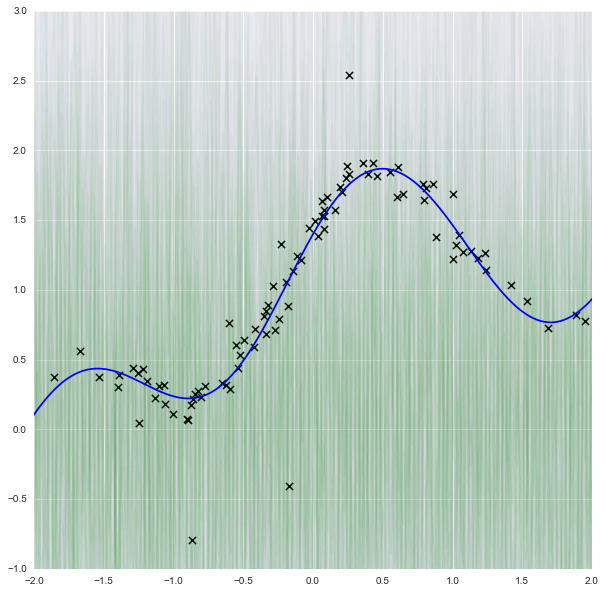

In [9]:
fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
prior_length_scale = []
prior_scale_factor = []
prior_noise_sigma = []
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    ripl.infer("reset_to_prior")
    prior_noise_sigma.append(ripl.sample("noise_sigma")) 
    prior_length_scale.append(ripl.sample("length_scale"))
    prior_scale_factor.append(ripl.sample("scale_factor"))
    xs= np.linspace(-3,3,200)
    ys = []
    for x in xs:
        ys.append(ripl.sample("observation_function(%d)" % (x,)))
        
  
    plt.plot(xs, ys,c="green",alpha=0.01,linewidth=2)

plt.axis((-2,2,-1,3))
plt.plot(x2plot,f2plot,color='blue')
plt.scatter(training_x,training_y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')

Fig 1: Samples from the GP - prior; no data has been observed - that is we do not condition on any input output relationships.

# Make Observations

In [11]:
for i in range(len(training_x)):
    ripl.observe("observation_function(%d)" % (training_x[i],),training_y[i])

## Inference

At the moment, I cannot be sure whether the inference instruction (below) actually works because the posterior distribution of both (hyper-parameters) and GP samples does not appear (by eye-balling) to move towards a posterior that reflects the observations (identifiable by visually).

In [12]:
ripl.infer("""mh(default, one, 100)""")

[6.03]

## What we need to get to run 

In [13]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

# Samples from Posterior

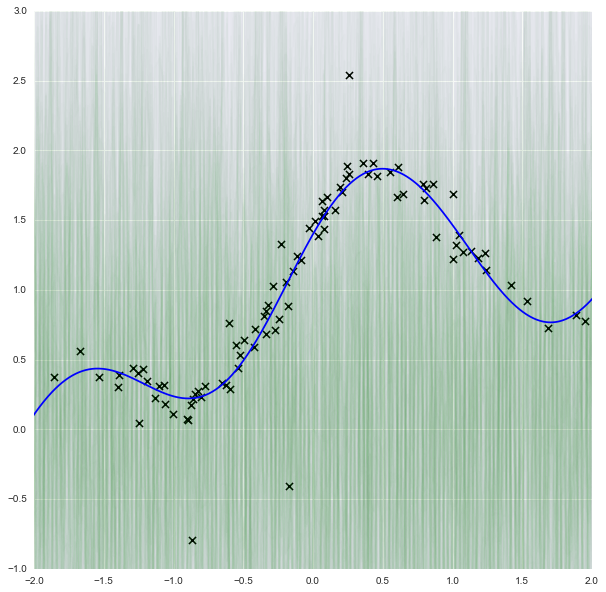

In [14]:
fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
posterior_length_scale = []
posterior_scale_factor = []
posterior_noise_sigma = []
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    ripl.infer("""mh("hyperhyper", all, 2)""")
    ripl.infer("""mh("hyper", 0, 1)""")
    posterior_noise_sigma.append(ripl.sample("noise_sigma"))
    ripl.infer("""mh("hyper", 1, 1)""")
    posterior_length_scale.append(ripl.sample("length_scale"))
    ripl.infer("""mh("hyper", 2, 1)""")
    posterior_scale_factor.append(ripl.sample("scale_factor"))
    #ripl.infer("""mh(default, one, 10)""")
    xs= np.linspace(-3,3,200)
    ys = []
    for x in xs:
        ys.append(ripl.sample("observation_function(%d)" % (x,)))
        
  
    plt.plot(xs, ys,c="green",alpha=0.01,linewidth=2)

plt.axis((-2,2,-1,3))
plt.plot(x2plot,f2plot,color='blue')
plt.scatter(training_x,training_y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')

Fig 2: Samples from the GP - posterior; now data has been observed and hyper-parameter inference was performed. That is we do condition on observed input output relationships and deploy the posterior samples of the hyper-parameters.

# Shift of Hyperprior to Hyperposterior

### Hyperprior

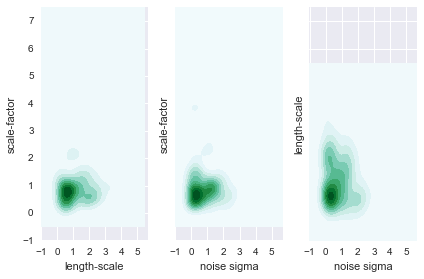

In [15]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(prior_length_scale), np.array(prior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_length_scale), shade=True, ax=axes[2])
axes[0].set_xlabel('length-scale')
axes[0].set_ylabel('scale-factor')
axes[1].set_xlabel('noise sigma')
axes[1].set_ylabel('scale-factor')
axes[2].set_xlabel('noise sigma')
axes[2].set_ylabel('length-scale')
f.tight_layout()

Fig 3: Samples from the Hyperparameter - prior; no data has been observed and no hyper-parameter inference was performed. That is we do not condition on observed input output relationships and deploy the prior samples of the hyper-parameters.

### Hyperposterior

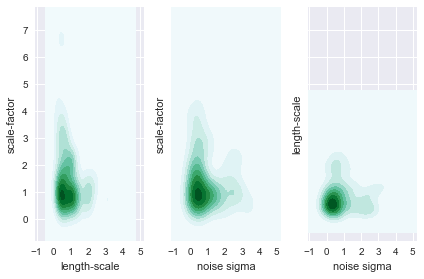

In [16]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(posterior_length_scale), np.array(posterior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_length_scale), shade=True, ax=axes[2])
axes[0].set_xlabel('length-scale')
axes[0].set_ylabel('scale-factor')
axes[1].set_xlabel('noise sigma')
axes[1].set_ylabel('scale-factor')
axes[2].set_xlabel('noise sigma')
axes[2].set_ylabel('length-scale')
f.tight_layout()

Fig 4: Samples from the Hyperparameter - posterior; now data has been observed and hyper-parameter inference was performed. That is we do condition on observed input output relationships and deploy the posterior samples of the hyper-parameters.